In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm
import sys
from scipy.integrate import simps, quadrature
from scipy.interpolate import interp1d
from scipy.interpolate import InterpolatedUnivariateSpline as ius
from scipy.interpolate import RectBivariateSpline
from time import time
import json

sys.path.append('../scripts/')
# from lab import *
import tools


In [2]:
dpath = '../PostBornEma/'
spath = '../scripts/'

In [3]:
ell_, t_, nu_n_, I0_ltrc, I2_ltrc, I4_ltrc = tools.loadfftlogdata()
t1, w1 = tools.loadggwts()
assert(np.allclose(t_,t1))

#Setup cosmology dicts                                                                                                                                                                                                                                                                    
with open(spath + 'class_cosmo_b.json', 'r') as fp: cosmo_b = json.load(fp)
for key in cosmo_b: cosmo_b[key] = np.array(cosmo_b[key])
with open(spath + 'cosmo_dict.json', 'r') as fp: cosmo_dict = json.load(fp)
for key in cosmo_dict: locals()[key] = cosmo_dict[key]



#prefactor for Cl_kk computation from Cl_dd                                                                                                                                                                                                                                               
c      = 299792458./1000. # km/s                                                                                                                                                                                                                                                          
Omega_b   = omega_b/h**2
Omega_cdm = omega_cdm/h**2
Omega_m   = Omega_b+Omega_cdm
prefac = 1.5*Omega_m*(100.)**2/c**2 #without h                                                                                                                                                                                                                                            


#Setup interpolating functions                                                                                                                                                                                                                                                            
class_z               = cosmo_b['z'][::-1]
class_chi             = cosmo_b['comov. dist.'][::-1]
class_D               = cosmo_b['gr.fac. D'][::-1]
class_H               = cosmo_b['H [1/Mpc]'][::-1]/h #already divided by c                                                                                                                                                                                                                

chi_z = interp1d(class_z,class_chi*h,fill_value=0, bounds_error=False)
z_chi = interp1d(class_chi*h,class_z,fill_value=0, bounds_error=False)  # Mpc/h                                                                                                                                                                                                           
D_chi = interp1d(class_chi*h,class_D,fill_value=0, bounds_error=False)    # growth                                                                                                                                                                                                        
D_z   = interp1d(class_z,class_D,fill_value=0, bounds_error=False)

#                                                                                                                                                                                                                                                                                         
chi_cmb = chi_z(z_cmb)
dchi_dz=(class_chi[1::]-class_chi[0:-1])/(class_z[1::]-class_z[0:-1])*h
z_mean = (class_z[1::]+class_z[0:-1])/2
dz_dchi = interp1d(class_chi*h,class_H,fill_value=0, bounds_error=False)
dchi_dz = interp1d(z_mean,dchi_dz,fill_value=0, bounds_error=False)



# Check your txt files

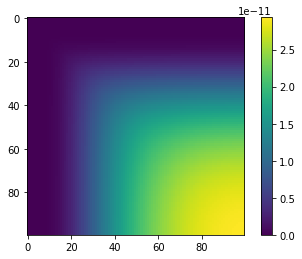

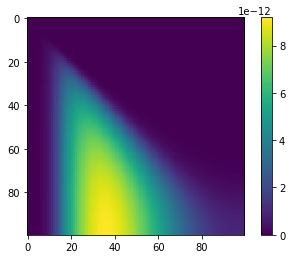

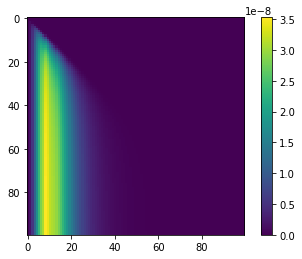

In [129]:
clpp = np.load('../G_matrices/clphiphi_parallel.npy')
clppsi = np.load('../G_matrices/clphipsi.npy')
clpdel = np.load('../G_matrices/clphidelta.npy')

ii = 10
# im = plt.imshow(np.log(clpp[ii]))
im = plt.imshow((clpp[ii]))
plt.colorbar(im)
plt.show()
# im = plt.imshow(np.log(clppsi[ii]))
im = plt.imshow((clppsi[ii]))
plt.colorbar(im)
plt.show()
# im = plt.imshow(np.log(clpdel[ii]))
im = plt.imshow((clpdel[ii]))
plt.colorbar(im)
plt.show()

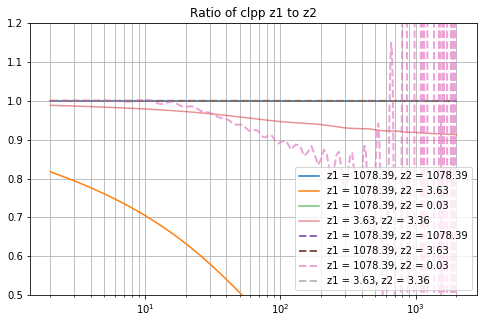

In [82]:
chis = np.loadtxt('../output/chis.txt')
clpp = np.load('../G_matrices/clphiphi.npy')
# clpp = np.load('../G_matrices/clphiphi_parallel.npy')
# clpp = np.load('../output/clphiphi.npy')
plt.figure(figsize = (8, 5))

ell = ell_
for ic, iz in enumerate([[99, 99], [99, 50], [99, 5], [50, 49]]):
    ii, jj = iz
    
#     plt.plot(ell, (ell*(ell+1))**2*clpp[:, ii, jj], label='z1 = %0.2f, z2 = %0.2f'%(z_chi(chis[ii]), z_chi(chis[jj])))
    plt.plot(ell, clpp[:, ii, jj]/clpp[:, jj, ii],  label='z1 = %0.2f, z2 = %0.2f'%(z_chi(chis[ii]), z_chi(chis[jj])), alpha=2/(ic+1))

clpp = np.load('../G_matrices/clphiphi_parallel.npy')
# clpp = np.load('../output/clphiphi.npy')

ell = ell_
for ic, iz in enumerate([[99, 99], [99, 50], [99, 5], [50, 49]]):
    ii, jj = iz
    
#     plt.plot(ell, (ell*(ell+1))**2*clpp[:, ii, jj], label='z1 = %0.2f, z2 = %0.2f'%(z_chi(chis[ii]), z_chi(chis[jj])))
    plt.plot(ell, clpp[:, ii, jj]/clpp[:, jj, ii],  '--', label='z1 = %0.2f, z2 = %0.2f'%(z_chi(chis[ii]), z_chi(chis[jj])), alpha=2/(ic+1), lw=2)

plt.title('Ratio of clpp z1 to z2')
plt.legend()
plt.xscale('log')
plt.ylim(0.5, 1.2)
plt.grid(which='both')
plt.show()




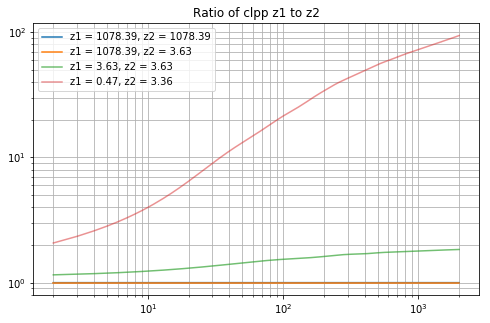

In [88]:
chis = np.loadtxt('../output/chis.txt')
clpp = np.load('../G_matrices/clphiphi.npy')
clpp2 = np.load('../G_matrices/clphiphi_parallel.npy')
# clpp = np.load('../output/clphiphi.npy')
plt.figure(figsize = (8, 5))

ell = ell_
for ic, iz in enumerate([[99, 99], [99, 50], [50, 50], [23, 49]]):
    ii, jj = iz
    
#     plt.plot(ell, (ell*(ell+1))**2*clpp[:, ii, jj], label='z1 = %0.2f, z2 = %0.2f'%(z_chi(chis[ii]), z_chi(chis[jj])))
    plt.plot(ell, clpp[:, ii, jj]/clpp2[:, ii, jj],  label='z1 = %0.2f, z2 = %0.2f'%(z_chi(chis[ii]), z_chi(chis[jj])), alpha=2/(ic+1))

plt.title('Ratio of clpp z1 to z2')
plt.legend()
plt.xscale('log')
plt.yscale('log')
# plt.ylim(0.5, 1.2)
plt.grid(which='both')
plt.show()




# compare things with VB

/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


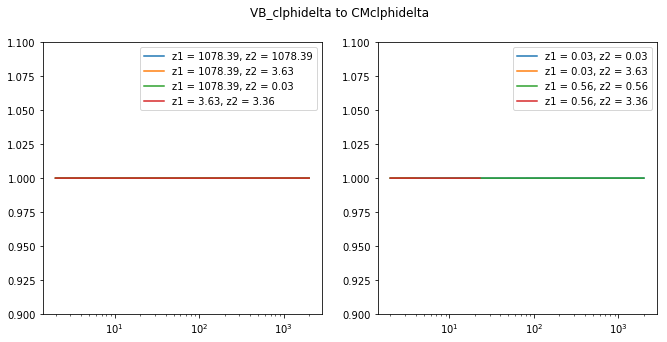

In [24]:
chis = np.loadtxt('../output/clphiphi/chis.txt')

vbclpd = np.load('../G_matrices/clphidelta.npy')
# vbclpd2 = np.load('../G_matrices/clphidelta2.npy')
cmclpd = np.load('../output/clphidelta.npy')

# test = []
# for i in range(100):
#     test.append(np.loadtxt('../output/clphidelta/%d.txt'%i))
# test = np.swapaxes(np.array(test), 0, 1)
# np.save('../output/clphidelta.npy', test)

t1 = cmclpd
t2 = vbclpd

plt.figure(figsize = (11, 5))
for ic, i in enumerate([[99, 99], [99, 50], [99, 5], [50, 49]]):
    ii, jj = i
    ax = plt.subplot(1, 2, 1)
    ax.plot(ell_, t1[:, ii, jj]/t2[:, ii, jj], 
            label='z1 = %0.2f, z2 = %0.2f'%(z_chi(chis[ii]), z_chi(chis[jj])))
    ax.legend()
    ax.set_xscale('log')
    ax.set_ylim(0.9, 1.1)


for ic, i in enumerate([[5, 5], [5, 50], [25, 25], [25, 49]]):
    ii, jj = i
    ax = plt.subplot(1, 2, 2)
    ax.plot(ell_, t1[:, ii, jj]/t2[:, ii, jj],  
            label='z1 = %0.2f, z2 = %0.2f'%(z_chi(chis[ii]), z_chi(chis[jj])))
    ax.legend()
    ax.set_xscale('log')
    ax.set_ylim(0.9, 1.1)

plt.suptitle('VB_clphidelta to CMclphidelta')
plt.show()

/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


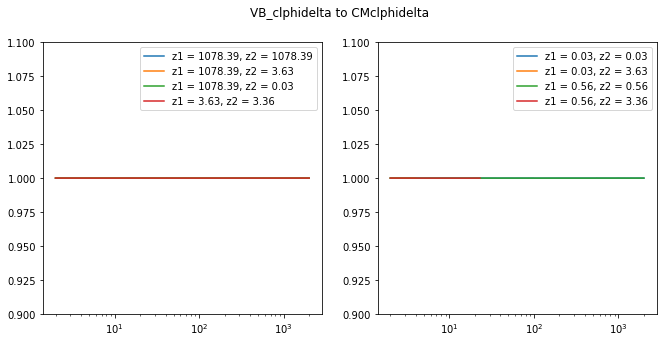

In [25]:
chis = np.loadtxt('../output/clphiphi/chis.txt')

vbclppsi = np.load('../G_matrices/clphipsi.npy')
# vbclppsi = np.swapaxes(vbclppsi, 0, 1)
cmclppsi = np.load('../output/clphipsi.npy')
# test = []
# for i in range(100):
#     test.append(np.loadtxt('../output/clphipsi/%d.txt'%i))
# test = np.swapaxes(np.array(test), 0, 1)

# # np.save('../output/clphipsi.npy', test)

t1 = cmclppsi
t2 = vbclppsi

plt.figure(figsize = (11, 5))
for ic, i in enumerate([[99, 99], [99, 50], [99, 5], [50, 49]]):
    ii, jj = i
    ax = plt.subplot(1, 2, 1)
    ax.plot(ell_, t1[:, ii, jj]/t2[:, ii, jj], 
            label='z1 = %0.2f, z2 = %0.2f'%(z_chi(chis[ii]), z_chi(chis[jj])))
    ax.legend()
    ax.set_xscale('log')
    ax.set_ylim(0.9, 1.1)


for ic, i in enumerate([[5, 5], [5, 50], [25, 25], [25, 49]]):
    ii, jj = i
    ax = plt.subplot(1, 2, 2)
    ax.plot(ell_, t1[:, ii, jj]/t2[:, ii, jj],  
            label='z1 = %0.2f, z2 = %0.2f'%(z_chi(chis[ii]), z_chi(chis[jj])))
    ax.legend()
    ax.set_xscale('log')
    ax.set_ylim(0.9, 1.1)

plt.suptitle('VB_clphidelta to CMclphidelta')
plt.show()

In [220]:
r2d - t_.reshape(1, -1)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [42]:
chis = np.loadtxt('../output/clphiphi/chis.txt')

cmclpp = np.load('../output/clphiphi.npy')
vbclpp = np.load('../G_matrices/clphiphi_parallel.npy')
# # vbgetclpp = np.load('../G_matrices/clphiphi_parallel_vbcm.npy')

t1 = cmclpp
t2 = vbclpp

plt.figure(figsize = (11, 5))
for ic, i in enumerate([[99, 99], [99, 50], [99, 5], [50, 49]]):
    ii, jj = i
    ax = plt.subplot(1, 2, 1)
    ax.plot(ell_, t1[:, ii, jj]/t2[:, ii, jj], 
            label='z1 = %0.2f, z2 = %0.2f'%(z_chi(chis[ii]), z_chi(chis[jj])))
    ax.legend()
    ax.set_xscale('log')
    ax.set_ylim(0.9, 1.1)


for ic, i in enumerate([[5, 5], [5, 50], [25, 25], [25, 49]]):
    ii, jj = i
    ax = plt.subplot(1, 2, 2)
    ax.plot(ell_, t1[:, ii, jj]/t2[:, ii, jj],  
            label='z1 = %0.2f, z2 = %0.2f'%(z_chi(chis[ii]), z_chi(chis[jj])))
    ax.legend()
    ax.set_xscale('log')
    ax.set_ylim(0.9, 1.1)

plt.suptitle('VB_clphidelta to CMclphidelta')
plt.show()

OSError: ../output/clphiphi/chis.txt not found.

/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


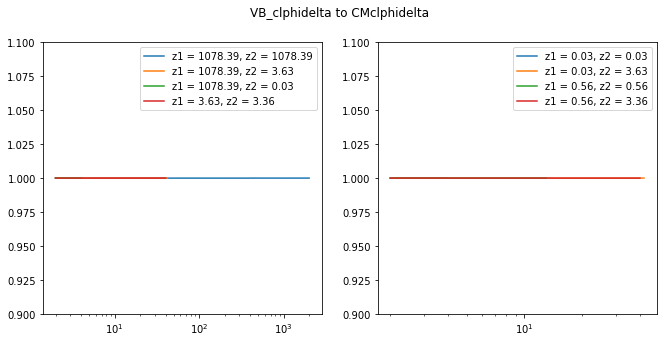

In [112]:
chis = np.loadtxt('../output/chis.txt')

t1 = np.swapaxes(np.load('../G_matrices/cldeltapsi.npy'), 1, 2)
t2 = np.load('../output/cldeltapsi.npy')
# t1 = np.load('../output/clpsidelta.npy')

plt.figure(figsize = (11, 5))
for ic, i in enumerate([[99, 99], [99, 50], [99, 5], [50, 49]]):
    ii, jj = i
    ax = plt.subplot(1, 2, 1)
    ax.plot(ell_, t1[:, ii, jj]/t2[:, ii, jj], 
            label='z1 = %0.2f, z2 = %0.2f'%(z_chi(chis[ii]), z_chi(chis[jj])))
    ax.legend()
    ax.set_xscale('log')
    ax.set_ylim(0.9, 1.1)


for ic, i in enumerate([[5, 5], [5, 50], [25, 25], [25, 49]]):
    ii, jj = i
    ax = plt.subplot(1, 2, 2)
    ax.plot(ell_, t1[:, ii, jj]/t2[:, ii, jj],  
            label='z1 = %0.2f, z2 = %0.2f'%(z_chi(chis[ii]), z_chi(chis[jj])))
    ax.legend()
    ax.set_xscale('log')
#     ax.set_yscale('log')
    
    ax.set_ylim(0.9, 1.1)

plt.suptitle('VB_clphidelta to CMclphidelta')
plt.show()

In [115]:
t2[:, 0]

array([[ 2.5059e-15,  6.9541e-14,  4.1971e-13, ...,  7.0406e-08,
         7.0463e-08,  7.0495e-08],
       [ 1.0989e-19,  1.6065e-17,  2.3821e-16, ...,  1.8504e-08,
         1.8521e-08,  1.8531e-08],
       [ 1.0163e-23,  7.8264e-21,  2.8510e-19, ...,  6.8452e-09,
         6.8520e-09,  6.8557e-09],
       ...,
       [ 0.0000e+00,  0.0000e+00,  0.0000e+00, ...,  1.6580e-17,
         7.4820e-18,  5.9723e-18],
       [ 0.0000e+00,  0.0000e+00,  0.0000e+00, ...,  9.5836e-18,
         2.4764e-19, -1.2799e-18],
       [ 0.0000e+00,  0.0000e+00,  0.0000e+00, ...,  2.5966e-18,
        -6.7903e-18, -8.3066e-18]])

/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


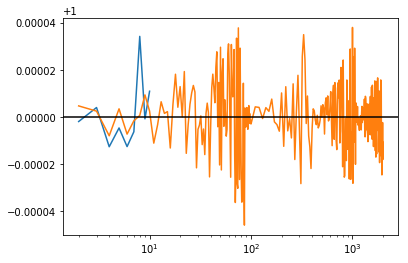

In [108]:
ii, jj = 55, 20
fac = 1+z_chi(chis[ii])
fac = (chis[ii])
fac = 1/D_chi(chis[ii])
plt.plot(ell, t1[:, ii, jj]/t2[:, ii, jj]/fac)

ii, jj = 99, 99
fac = 1+z_chi(chis[ii])
fac = (chis[ii])
fac = 1/D_chi(chis[ii])
plt.plot(ell, t1[:, ii, jj]/t2[:, ii, jj]/fac)
plt.axhline(1, color='k')
plt.xscale('log')

# Limber Cldeltapsi

In [141]:
pk = np.loadtxt('../PostBornEma/pk_Planck2018BAO_matterpower_z000.dat')
ipk = ius(pk[:, 0], pk[:, 1], k=5)


In [146]:

r2d, t2d = np.meshgrid(t_,t_)

chigrid = r2d*chi_cmb
chigrid2= r2d*chi_cmb*t2d
# print((chigrid[-1,:]-chigrid2[-1,:])/chigrid2[-1,:])

chis1 = chigrid[-1,:]
chis2 = chigrid2[-1,:]
Cldeltapsi=np.zeros((len(ell_),len(t_),len(t_)))
for ii, ell in enumerate(ell_):
   k1 = ell/chigrid
   k2 = ell/chigrid2
   Cldeltapsi[ii] = D_chi(chigrid)*D_chi(chigrid2)*np.sqrt(ipk(k1)*ipk(k2))/k2**2*(1.+z_chi((chigrid2)))*prefac

In [216]:
t_*chi_cmb/chigrid2[-1]

array([1.00014316, 1.00014316, 1.00014316, 1.00014316, 1.00014316,
       1.00014316, 1.00014316, 1.00014316, 1.00014316, 1.00014316,
       1.00014316, 1.00014316, 1.00014316, 1.00014316, 1.00014316,
       1.00014316, 1.00014316, 1.00014316, 1.00014316, 1.00014316,
       1.00014316, 1.00014316, 1.00014316, 1.00014316, 1.00014316,
       1.00014316, 1.00014316, 1.00014316, 1.00014316, 1.00014316,
       1.00014316, 1.00014316, 1.00014316, 1.00014316, 1.00014316,
       1.00014316, 1.00014316, 1.00014316, 1.00014316, 1.00014316,
       1.00014316, 1.00014316, 1.00014316, 1.00014316, 1.00014316,
       1.00014316, 1.00014316, 1.00014316, 1.00014316, 1.00014316,
       1.00014316, 1.00014316, 1.00014316, 1.00014316, 1.00014316,
       1.00014316, 1.00014316, 1.00014316, 1.00014316, 1.00014316,
       1.00014316, 1.00014316, 1.00014316, 1.00014316, 1.00014316,
       1.00014316, 1.00014316, 1.00014316, 1.00014316, 1.00014316,
       1.00014316, 1.00014316, 1.00014316, 1.00014316, 1.00014

In [160]:
cmcldp = np.load('../output/cldeltapsi.npy')
vbcldp = np.load('../G_matrices/cldeltapsi.npy')


In [164]:
ell1 = ell_.reshape(-1, 1)
t2 = t_.reshape(1, -1)
k12 = ell1/t2/chi_cmb

Cldeltapsidiag = D_chi(t2*chi_cmb)**2 *ipk(k12)/k12**2*(1.+z_chi(t2*chi_cmb))*prefac

In [168]:
Cldeltapsidiag.shape

(289, 100)

$ G_l^{\psi\delta}(\chi_1, \chi_2)
= \mathcal{A} \frac{1}{2\pi^2} D(\chi_2) D(\chi_1)  [1+z(\chi_1)] \sum_n \left[I^{(2)}_l (\nu_n,\chi_1/\chi_2)\chi_2^{-(\nu_n+2)} +I^{(2)}_l (\nu_n,\chi_2/\chi_1) \chi_1^{-(\nu_n+2)}\right]$

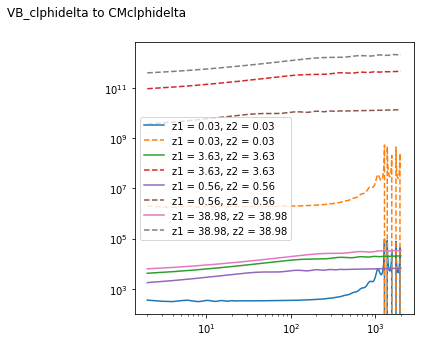

In [209]:
chis = np.loadtxt('../output/chis.txt')

t1 = Cldeltapsi
# t2 = cmcldp
t2 = np.swapaxes(vbcldp, 1, 1)

# t1 = np.load('../output/clpsidelta.npy')

plt.figure(figsize = (11, 5))
# for ic, i in enumerate([[99, 99], [99, 50], [99, 5], [50, 49]]):
#     ii, jj = i
#     ax = plt.subplot(1, 2, 1)
# #     ax.plot(ell_, t1[:, ii, jj]/t2[:, ii, jj], 
# #             label='z1 = %0.2f, z2 = %0.2f'%(z_chi(chis[ii]), z_chi(chis[jj])))
#     ax.plot(ell_, t1[:, ii, jj], 'C%d'%ic, label='z1 = %0.2f, z2 = %0.2f'%(z_chi(chis[ii]), z_chi(chis[jj])))
#     ax.plot(ell_, t2[:, ii, jj], 'C%d--'%ic, )
#     ax.legend()
#     ax.set_xscale('log')
#     ax.set_yscale('log')
# #     ax.set_ylim(0.9, 1.1)


for ic, i in enumerate([[5, 5], [50, 50], [25, 25], [75, 75]]):
    ii, jj = i
    ax = plt.subplot(1, 2, 2)
    ax.plot(ell_, t1[:, -1, jj]/t2[:, -1, jj]*ell_/((chis[jj]))**2,  
            label='z1 = %0.2f, z2 = %0.2f'%(z_chi(chis[ii]), z_chi(chis[jj])))
    ax.plot(ell_, t1[:, -1, jj]/t2[:, -1, jj]*ell_,  '--',
            label='z1 = %0.2f, z2 = %0.2f'%(z_chi(chis[ii]), z_chi(chis[jj])))
#     ax.plot(ell_, t1[:, -1, jj], 'C%d'%ic, label='z1 = %0.2f, z2 = %0.2f'%(z_chi(chis[ii]), z_chi(chis[jj])))
#     ax.plot(ell_, t2[:, -1, jj], 'C%d--'%ic, )
#     ax.plot(ell_, Cldeltapsidiag[:, ii], 'C%d:'%ic, lw=2)
    
    ax.legend()
    ax.set_xscale('log')
    ax.set_yscale('log')
    
#     ax.set_ylim(0.9, 1.1)

plt.suptitle('VB_clphidelta to CMclphidelta')
plt.show()

# Integrals

\begin{eqnarray}
C_l^{ab}(\chi_1, \chi_2) &=& \int \frac{dk}{k} j_l(k\chi_1)j_l(k\chi_2) [k^3 P^{ab}(k, \chi_1, \chi_2)] \\
&=& \sum_n c_n \chi_1 ^{-\nu_n} I_l(\nu_n, \frac{\chi_2}{\chi_1})
\end{eqnarray}
(dropped 1/$4\pi$)

\begin{eqnarray}
G^{ab}(l, \chi, \chi') &=& \int_0^{\chi} d\chi" W(\chi", \chi) C_l^{ab}(\chi', \chi")  \\
&=&\int_0^{\chi} d\chi" W(\chi", \chi) \sum_n c_n \chi' ^{-\nu_n} I_l^{ab}(\nu_n, \frac{\chi''}{\chi'}) 
\end{eqnarray}
<br>


In the following, drop the integral over $\ell$

- $C_{22shift, A}^{\kappa g}$ i.e. eq. 4.2 second term :
<br>
\begin{eqnarray}
C_{22shift, A}^{\kappa g} &=& \int_0^{\chi_c}  d\chi W(\chi, \chi_c)\int_0^{\chi_0} d\chi' W_h(\chi')
C_{l1}^{\delta \Psi}(\chi', \chi) C_{l2}^{\phi\phi}(\chi', \chi) \\
&=&\int_0^{\chi_c} d\chi W(\chi, \chi_c)  \int_0^{\chi_0} d\chi' W_h(\chi') C_{l1}^{\delta \Psi}(\chi', \chi) 
\int_0^{\chi'} d\chi" W(\chi", \chi') 
\int_0^{\chi} d\chi''' W(\chi''', \chi) C_{l2}^{\Psi \Psi}(\chi', \chi''') 
\end{eqnarray}

Notes - here, we can create a table of ($\chi, \chi'$) for the second half i.e. $\int_0^{\chi'} d\chi" W(\chi", \chi') 
\int_0^{\chi} d\chi''' W(\chi''', \chi) C_{l2}^{\Psi \Psi}(\chi', \chi''') $, then simply multiply with other $I_{l1}^{\delta \Psi}$ and do the remaining 2 integrals with GC
 

- $C_{22shift, B}^{\kappa g}$ i.e. eq. 4.2 second term :
<br>
\begin{eqnarray}
C_{22shift, B}^{\kappa g} &=& \int_0^{\chi_c}  d\chi W(\chi, \chi_c)\int_0^{\chi_0} d\chi' W_h(\chi')
C_{l1}^{\Phi \Psi}(\chi', \chi) C_{l2}^{\delta\phi}(\chi', \chi) \\
&=&\int_0^{\chi_c} d\chi W(\chi, \chi_c)  \int_0^{\chi_0} d\chi' W_h(\chi')
\int_0^{\chi'} d\chi" W(\chi", \chi') C_{l1}^{\Psi \Psi}(\chi", \chi) 
\int_0^{\chi} d\chi''' W(\chi''', \chi) C_{l2}^{\delta \Psi}(\chi', \chi''') 
\end{eqnarray}

Notes - here, we can create use table of $G_{l_2, \chi, \chi'}^{\delta \Psi}$ and $G_{l_1, \chi, \chi'}^{\Psi \Psi}$, multiply them and then do the the remaining 2 integrals with GC

- $C_{31ashift, A}^{\kappa g}$ i.e. eq. 4.3 :
<br>
\begin{eqnarray}
C_{31ashift, A}^{\kappa g} &=& \int_0^{\chi_c}  d\chi W(\chi, \chi_c)\int_0^{\chi_0} d\chi' W_h(\chi')
C_{l1}^{\delta \Psi}(\chi', \chi) C_{l2}^{\phi\phi}(\chi, \chi) \\
&=&\int_0^{\chi_c} d\chi W(\chi, \chi_c)  \int_0^{\chi_0} d\chi' W_h(\chi') C_{l1}^{\delta \Psi}(\chi', \chi) 
\int_0^{\chi} d\chi" W(\chi", \chi) 
\int_0^{\chi} d\chi''' W(\chi''', \chi) C_{l2}^{\Psi \Psi}(\chi", \chi''') 
\end{eqnarray}

Notes - here again, same as 22A, we can create a table of ($\chi$) for the second half i.e. $\int_0^{\chi} d\chi" W(\chi", \chi) 
\int_0^{\chi} d\chi''' W(\chi''', \chi) C_{l2}^{\Psi \Psi}(\chi, \chi''') $, put it in the kernel of $\chi$; integrate out $\chi'$ first with GC and then do the full $\chi$ integral with GC


- $C_{31ashift, B}^{\kappa g}$ i.e. eq. 4.4 :
<br>
\begin{eqnarray}
C_{31ashift, B}^{\kappa g} &=& \int_0^{\chi_c}  d\chi W(\chi, \chi_c) \int_0^{\chi_0} d\chi' W_h(\chi')
C_{l}^{\Phi \Psi}(\chi, \chi) C_{L}^{\delta\phi}(\chi', \chi) \\
&=&\int_0^{\chi_c} d\chi W(\chi, \chi_c)  \int_0^{\chi_0} d\chi' W_h(\chi')
\int_0^{\chi} d\chi" W(\chi", \chi) C_{l}^{\Psi \Psi}(\chi", \chi) 
\int_0^{\chi} d\chi''' W(\chi''', \chi) C_{L}^{\delta \Psi}(\chi', \chi''') 
\end{eqnarray}

Notes - here again, we can do integral over $\chi'$ and $\chi"$ trivially, combine everything into the kernel of $\chi$ and then estimate that with GC


- $C_{13ashift}^{\kappa g}$ i.e. eq. 4.5 :
<br>
\begin{eqnarray}
C_{13ashift}^{\kappa g} &=& \int_0^{\chi_c}  d\chi W(\chi, \chi_c) \int_0^{\chi_0} d\chi' W_h(\chi')
C_{l1}^{\delta \Psi}(\chi', \chi) C_{l2}^{\phi\phi}(\chi', \chi') \\
&=&\int_0^{\chi_c} d\chi W(\chi, \chi_c)  \int_0^{\chi_0} d\chi' W_h(\chi') C_{l1}^{\delta \Psi}(\chi', \chi) 
\int_0^{\chi'} d\chi" W(\chi", \chi') 
\int_0^{\chi'} d\chi''' W(\chi''', \chi') C_{l2}^{\Psi \Psi}(\chi", \chi''') 
\end{eqnarray}

Notes - here again, same as 31a,A, except we can create a table of ($\chi'$) for the second half i.e. $\int_0^{\chi'} d\chi" W(\chi", \chi') 
\int_0^{\chi'} d\chi''' W(\chi''', \chi') C_{l2}^{\Psi \Psi}(\chi", \chi''') $, put it in the kernel of $\chi'$; then integrate out $\chi'$ and $\chi$ in the usual manner



- $C_{31bshift}^{\kappa g}$ i.e. eq. 4.6-3.7 :
<br>
\begin{eqnarray}
C_{31bshift}^{\kappa g} &=& \int_0^{\chi_c}  d\chi W(\chi, \chi_c) \int_0^{\chi_0} d\chi' W_h(\chi')
\int_0^{\chi}  d\chi" W(\chi", \chi) C_{l1}^{\Psi \Psi}(\chi", \chi) C_{l2}^{\phi\delta}(\chi", \chi') \\
&=&\int_0^{\chi_c} d\chi W(\chi, \chi_c)  \int_0^{\chi_0} d\chi' W_h(\chi') 
\int_0^{\chi}  d\chi" W(\chi", \chi) C_{l1}^{\Psi \Psi}(\chi", \chi)
\int_0^{\chi"} d\chi''' W(\chi''', \chi") C_{l2}^{\Psi\delta}(\chi''', \chi')  
\end{eqnarray}

Notes - here we can do the $\chi', \chi'''$ integrals first  in the usual fashion to create a table of $\chi"$ and then use them as weights to do $\chi, \chi''$ integrals later

- $C_{13bshift}^{\kappa g}$ i.e. eq. 4.8 :
<br>
\begin{eqnarray}
C_{13shift}^{\kappa g} &=& \int_0^{\chi_c}  d\chi W(\chi, \chi_c) \int_0^{\chi_0} d\chi' W_h(\chi')
\int_0^{\chi'}  d\chi" W(\chi", \chi) C_{l1}^{\Psi \Psi}(\chi", \chi) ...
\end{eqnarray}

Notes - ...

- $C_{13, J}^{\kappa g}$ i.e. eq. 4.8 :
<br>
\begin{eqnarray}
C_{13shift}^{\kappa g} &=& \int_0^{\chi_c}  d\chi W(\chi, \chi_c) \int_0^{\chi_0} d\chi' W_h(\chi')
\int_0^{\chi'}  d\chi" W(\chi", \chi) C_{l1}^{\Psi \Psi}(\chi", \chi) C_{l2}^{\phi\delta} ...
\end{eqnarray}

Notes - ...

# Check cl22

In [107]:
cmcl22amesh = np.load('../output/cl22a.npy')
cmcl22arevmesh = np.load('../output/cl22a-reverse.npy')
vbma = np.load('../M_matrices/MA_matrix_bin_all.npy')
vbmatilde = np.load('../M_matrices/tildeMA_matrix_bin_all.npy')


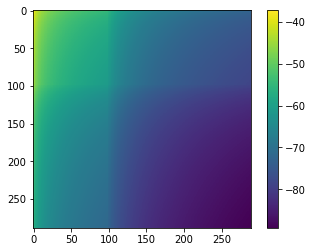

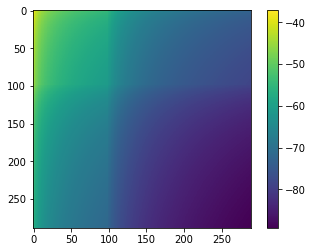

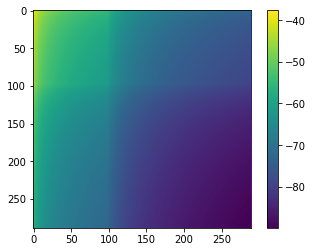

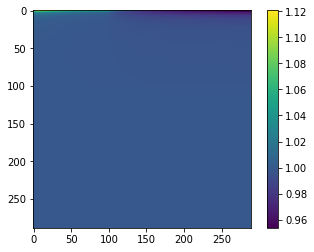

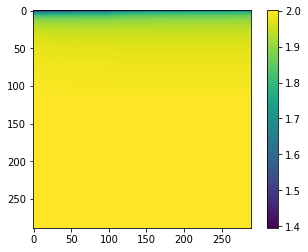

In [108]:
im = plt.imshow(np.log(cmcl22amesh))
plt.colorbar(im)
plt.show()
im = plt.imshow(np.log(cmcl22arevmesh))
plt.colorbar(im)
plt.show()
im = plt.imshow(np.log(vbma))
plt.colorbar(im)
plt.show()
im = plt.imshow(cmcl22arevmesh/cmcl22amesh)
plt.colorbar(im)
plt.show()
im = plt.imshow(cmcl22amesh/vbma)
plt.colorbar(im)
plt.show()


Text(0.5, 1.0, 'CM-MA / VB-MA')

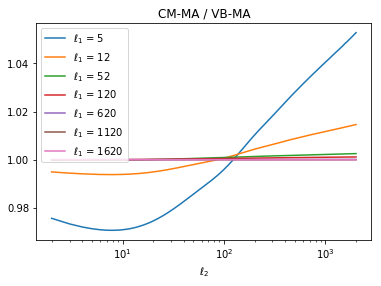

In [112]:
for ii in [3, 10, 50, 100, 150, 200, 250]:
#     plt.plot(ell_, cmcl22a[ii]/vbma[ii], label='$\ell_1$ = %d'%ell_[ii])
    plt.plot(ell_, cmcl22a[ii]/cmcl22arev[ii], label='$\ell_1$ = %d'%ell_[ii])
plt.legend()
plt.xscale('log')
plt.xlabel('$\ell_2$')
plt.title('CM-MA / VB-MA')

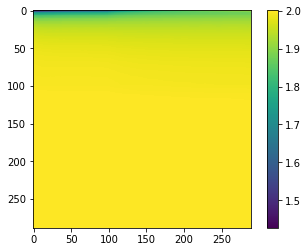

In [105]:
im = plt.imshow(cmcl22a/vbma)
plt.colorbar(im)

In [136]:
cmcl22bmesh = np.load('../output/cl22b.npy')


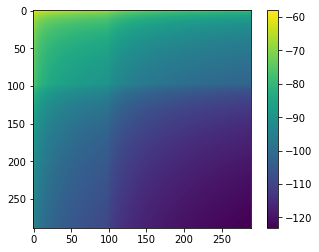

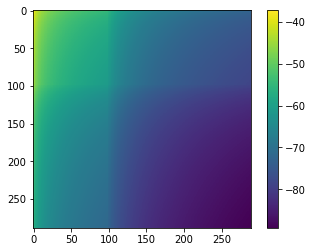

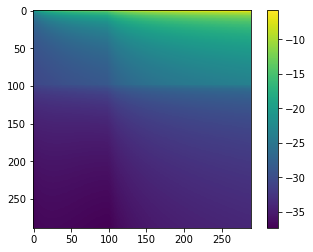

In [138]:
im = plt.imshow(np.log(cmcl22bmesh))
plt.colorbar(im)
plt.show()
im = plt.imshow(np.log(cmcl22amesh))
plt.colorbar(im)
plt.show()
im = plt.imshow(np.log(cmcl22bmesh/cmcl22amesh))
plt.colorbar(im)
plt.show()

# Cl31aA

In [113]:
def get_31_term(M,L,L1):
    return L**4/4./np.pi*np.trapz(M(L,L1)*L1**3,L1)

L,Cl31s = np.load('../output/LimberPostBornCl31_kappa-gal.npy')

# L,Cl31_cut = np.load('../output/LimberPostBornCl31_kappa-gal_all_cut.npy')


In [114]:
cl31aAmesh = np.load('../output/cl31aA.npy')
cl31aAv2mesh = np.load('../output/cl31aA-v2.npy')
# cl31aAv3mesh = np.load('../output/cl31aA-v3.npy')
# cl31aAv4mesh = np.load('../output/cl31aA-v4.npy')

icl31aAmesh  = RectBivariateSpline(ell_,ell_,cl31aAmesh)
icl31aAv2mesh  = RectBivariateSpline(ell_,ell_,cl31aAv2mesh)
# icl31aAv3mesh  = RectBivariateSpline(ell_,ell_,cl31aAv3mesh)
# icl31aAv4mesh  = RectBivariateSpline(ell_,ell_,cl31aAv4mesh)


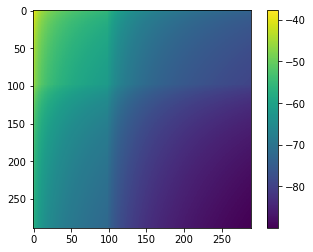

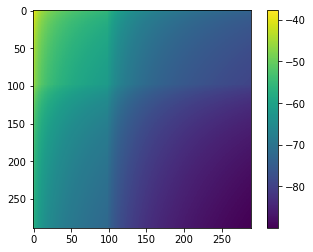

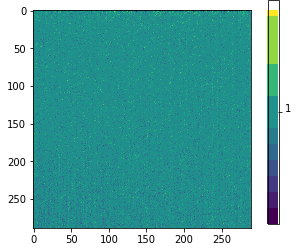

In [115]:
im = plt.imshow(np.log(cl31aAmesh))
plt.colorbar(im)
plt.show()
im = plt.imshow(np.log(cl31aAv2mesh))
plt.colorbar(im)
plt.show()
im = plt.imshow(cl31aAmesh/cl31aAv2mesh)
plt.colorbar(im)
plt.show()
# im = plt.imshow(np.log(cl31aAv3mesh))
# plt.colorbar(im)
# plt.show()
# im = plt.imshow(cl31aAv3mesh/cl31aAmesh)
# plt.colorbar(im)
# plt.show()
# im = plt.imshow(cl31aAv3mesh/cl31aAv2mesh)
# plt.colorbar(im)
# plt.show()
# im = plt.imshow(np.log(cl31aAv4mesh))
# plt.colorbar(im)
# plt.show()
# im = plt.imshow(cl31aAv4mesh/cl31aAmesh)
# plt.colorbar(im)
# plt.show()
# im = plt.imshow(cl31aAv4mesh/cl31aAv2mesh)
# plt.colorbar(im)
# plt.show()
# im = plt.imshow(cl31aAv4mesh/cl31aAv3mesh)
# plt.colorbar(im)
# plt.show()


In [116]:
L     = np.logspace(1,4,400)
# sampling for integrations
phi = np.linspace(0.,2.*np.pi,1000,endpoint=True)
L1  = np.logspace(-1,5,400)

cl31a = get_31_term(icl31aAmesh, L, L1)
cl31av2 = get_31_term(icl31aAv2mesh, L, L1)
# cl31av3 = get_31_term(icl31aAv3mesh, L, L1)
# cl31av4 = get_31_term(icl31aAv4mesh, L, L1)

[]

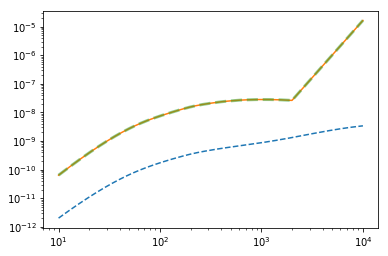

In [117]:
plt.plot(L, -Cl31s[-1], '--')
plt.plot(L, cl31a)
plt.plot(L, cl31av2, '--', lw=3, alpha=0.5)
plt.loglog()

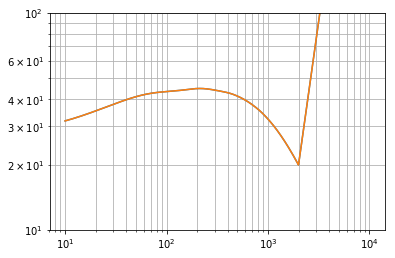

In [118]:
plt.plot(L, cl31a/-Cl31s[-1])
plt.plot(L, cl31av2/-Cl31s[-1])
plt.yscale('log')
plt.ylim(10, 100)
plt.xscale('log')
plt.grid(which='both')


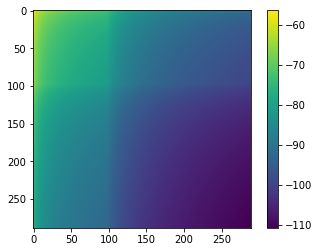

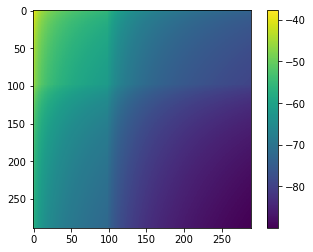

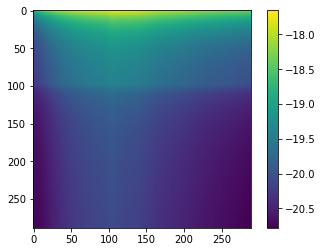

In [139]:
cl31aBmesh = np.load('../output/cl31aB.npy')

im = plt.imshow(np.log(cl31aBmesh))
plt.colorbar(im)
plt.show()
im = plt.imshow(np.log(cl31aAv2mesh))
plt.colorbar(im)
plt.show()
im = plt.imshow(np.log(cl31aBmesh/cl31aAmesh))
plt.colorbar(im)
plt.show()

# cl13a

In [96]:
cl13amesh = np.load('../output/cl13a.npy')
cl13av2mesh = np.load('../output/cl13a-v2.npy')

icl13amesh  = RectBivariateSpline(ell_,ell_,cl13amesh)
icl13av2mesh  = RectBivariateSpline(ell_,ell_,cl13av2mesh)

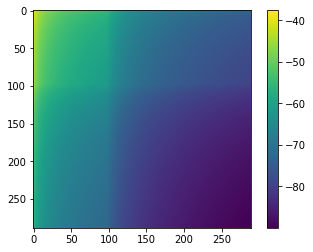

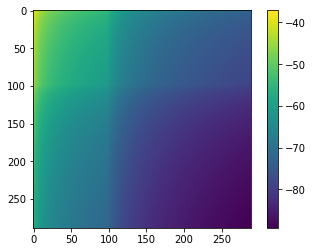

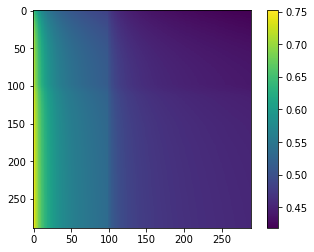

In [97]:
im = plt.imshow(np.log(cl13amesh))
plt.colorbar(im)
plt.show()
im = plt.imshow(np.log(cl13av2mesh))
plt.colorbar(im)
plt.show()
im = plt.imshow((cl13amesh/cl13av2mesh))
plt.colorbar(im)
plt.show()


In [98]:
cl13a = get_31_term(icl13amesh, L, L1)
cl13av2 = get_31_term(icl13av2mesh, L, L1)

[]

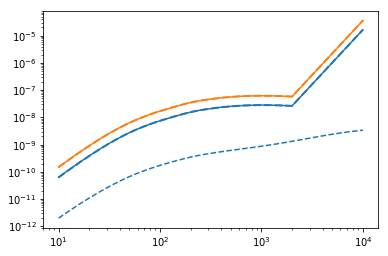

In [99]:
plt.plot(L, -Cl31s[-1], '--')
plt.plot(L, cl31a, 'C0')
plt.plot(L, cl31av2, 'C1')
plt.plot(L, cl13a, 'C0--', lw=2)
plt.plot(L, cl13av2, 'C1--', lw=2)
plt.loglog()

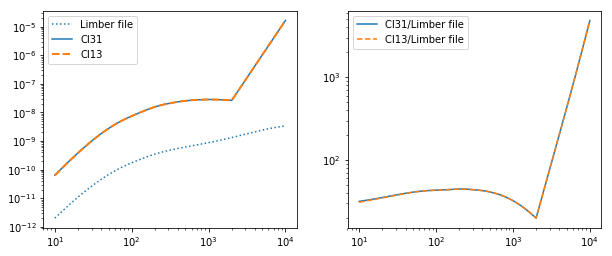

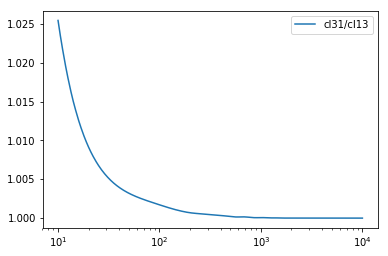

In [100]:
plt.figure( figsize = (10, 4))
ax = plt.subplot(1, 2, 1)
plt.plot(L, -Cl31s[-1], ':', label='Limber file')
plt.plot(L, cl31a, 'C0', label='Cl31')
plt.plot(L, cl13a, 'C1--', lw=2, label='Cl13')
plt.loglog()
plt.legend()
ax = plt.subplot(1, 2, 2)
plt.plot(L, cl31a/-Cl31s[-1], 'C0-', label='Cl31/Limber file')
plt.plot(L, cl13a/-Cl31s[-1], 'C1--', label='Cl13/Limber file')
plt.loglog()
plt.legend()
plt.show()
plt.plot(L, cl31a/cl13a, 'C0', label='cl31/cl13')
plt.xscale('log')
plt.legend()

# Test kernel

In [90]:
#Kernels                                                                                                                                                                                                                                                                                  
clppmesh = np.load('../G_matrices/clphiphi.npy')
chis = np.loadtxt('../output/chis.txt')
indexchi = {}
for i in range(chis.size): indexchi[chis[i]] = i


def lensing_kernel(xi, xmax):
    return (xmax - xi)/(xmax*xi) * (xmax > xi) * (1.+z_chi(xi))

##                                                                                                                                                                                                                                                                                        
galaxy_kernel = lambda xi, xmax : lsst_kernel_cb(xi)

r2d, t2d = np.meshgrid(t_,t_)
r2d, t2d = np.expand_dims(r2d, 2), np.expand_dims(t2d, 2)


In [95]:
def setup_galaxy_kernel(lindex):
    chifac = np.diag(clppmesh[int(lindex)]).reshape(-1, 1) #reshape is (-1, 1) if its for second kernel. (1, -1) for first kernel                                                                                                                                                         
    kernel = lambda  xi, xmax :  chifac * galaxy_kernel(xi, xmax)
    return kernel


kern = setup_galaxy_kernel(2)
print(kern(r2d*chi_cmb, 0).shape, kern(t2d*chi_cmb, 0).shape)
# print(((r2d*chi_cmb)* kern(t_.reshape(1, -1)*chi_cmb, 0)).shape, ((r2d*chi_cmb)* kern(t_.reshape(-1, 1)*chi_cmb, 0)).shape)
# print(((r2d*chi_cmb)* kern(t_.reshape(1, -1)*chi_cmb, 0)*(r2d*chi_cmb)**nu_n_.reshape(1, 1, -1)).shape, ((r2d*chi_cmb)* kern(t_.reshape(-1, 1)*chi_cmb, 0)*(r2d*chi_cmb)**nu_n_.reshape(1, 1, -1)).shape)

(100, 100, 1) (100, 100, 1)


In [100]:
(galaxy_kernel(r2d*chi_cmb, 0)*t_.reshape(1, -1)).shape

(100, 100, 100)

In [83]:
def setup_galaxy_kernel(lindex):
    chifac = np.diag(clppmesh[int(lindex)]).reshape(1, -1) #reshape is (-1, 1) if its for second kernel. (1, -1) for first kernel                                                                                                                                                         
    kernel = lambda  xi, xmax :  chifac * galaxy_kernel(xi, xmax)
    return kernel


kern = setup_galaxy_kernel(2)
print(kern(t_.reshape(1, -1)*chi_cmb, 0).shape, kern(t_.reshape(-1, 1)*chi_cmb, 0).shape)
print(((r2d*chi_cmb)* kern(t_.reshape(1, -1)*chi_cmb, 0)).shape, ((r2d*chi_cmb)* kern(t_.reshape(-1, 1)*chi_cmb, 0)).shape)
print(((r2d*chi_cmb)* kern(t_.reshape(1, -1)*chi_cmb, 0) *(r2d*chi_cmb)**nu_n_.reshape(1, 1, -1)).shape, )

(1, 100) (100, 100)
(100, 100) (100, 100)


ValueError: operands could not be broadcast together with shapes (100,100) (1,1,101) 

In [85]:
(r2d*chi_cmb)**(1-nu_n_.reshape(1, 1, -1))

ValueError: operands could not be broadcast together with shapes (100,100) (1,1,101) 

In [88]:
from getcl import getcl

getcl(lensing_kernel, lensing_kernel, chi_cmb, chi_cmb, 2, 1)

(100, 100, 1)
(100, 100, 1)


../scripts/getcl.py:37: ComplexWarning: Casting complex values to real discards the imaginary part
  result[ii] = np.sum(chifacs*I_ltrc[ii])


array([7.65059274e-06, 2.65262136e-06, 1.22344040e-06, 6.63365279e-07,
       3.99282703e-07, 2.58681155e-07, 1.77129242e-07, 1.26607788e-07,
       9.35778689e-08, 7.10338776e-08, 5.51419148e-08, 4.36581894e-08,
       3.51711063e-08, 2.87523608e-08, 2.37889645e-08, 1.98825377e-08,
       1.67714094e-08, 1.42739616e-08, 1.22531776e-08, 1.06008606e-08,
       9.23234117e-09, 8.08453752e-09, 7.11259214e-09, 6.28504995e-09,
       5.57858031e-09, 4.97423159e-09, 4.45538307e-09, 4.00725401e-09,
       3.61718185e-09, 3.27498459e-09, 2.97282231e-09, 2.70492834e-09,
       2.46694798e-09, 2.25538046e-09, 2.06717371e-09, 1.89949962e-09,
       1.74968144e-09, 1.61527470e-09, 1.49414455e-09, 1.38447157e-09,
       1.28480941e-09, 1.19399501e-09, 1.11112905e-09, 1.03544916e-09,
       9.66303296e-10, 9.03093634e-10, 8.45257242e-10, 7.92258293e-10,
       7.43586368e-10, 6.98784807e-10, 6.57433860e-10, 6.19170986e-10,
       5.83693787e-10, 5.50741922e-10, 5.20099648e-10, 4.91578898e-10,
      

In [71]:

r2d, t2d = np.meshgrid(t_,t_)   
r2d - t_.reshape(1, -1)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])